In [ ]:
!pip install --upgrade catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
warnings.filterwarnings("ignore")

import os, sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(os.getcwd())

/content


In [ ]:
os.chdir('/content/drive/MyDrive/colab/steel_plate_defect_prediction')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/colab/steel_plate_defect_prediction'

In [ ]:
os.listdir()

['data', 'steel-plate-defect-prediction']

In [ ]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df_test_ov = df_test.copy()
df_orig = pd.read_csv("./data/Faults.csv")

In [ ]:
df_train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [ ]:
df_test.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,...,0.0095,0.5652,1.0000,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172
1,19220,1257,1271,419960,419973,370,26,28,39293,92,...,0.0047,0.2414,1.0000,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104
2,19221,1358,1372,117715,117724,289,36,32,29386,101,...,0.0155,0.6000,0.7500,0.0,2.4609,1.3222,1.3222,-0.5238,-0.0435,0.6514
3,19222,158,168,232415,232440,80,10,11,8586,107,...,0.0037,0.8000,1.0000,1.0,1.9031,0.6990,1.0414,0.1818,-0.0738,0.2051
4,19223,559,592,544375,544389,140,19,15,15524,103,...,0.0158,0.8421,0.5333,0.0,2.1461,1.3222,1.1461,-0.5714,-0.0894,0.4170


In [ ]:
df_orig.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [ ]:
df_train.drop(columns=["id"], inplace=True)
df_test_id = df_test["id"]
df_test.drop(columns=["id"], inplace=True)
df_combined = pd.concat([df_train, df_orig],ignore_index=True)

In [ ]:
df_combined.shape

(21160, 34)

In [ ]:
df_combined.isnull().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

In [ ]:
df_test.isnull().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
dtype: int64

In [ ]:
label_columns=['Pastry','Z_Scratch', 'K_Scatch',   'Stains',   'Dirtiness','Bumps','Other_Faults']

In [ ]:
y_train=df_combined[label_columns]
X_train=df_combined.drop(columns=label_columns,axis=1)
X_test=df_test

In [ ]:
X_train.shape, X_test.shape,y_train.shape

((21160, 27), (12814, 27), (21160, 7))

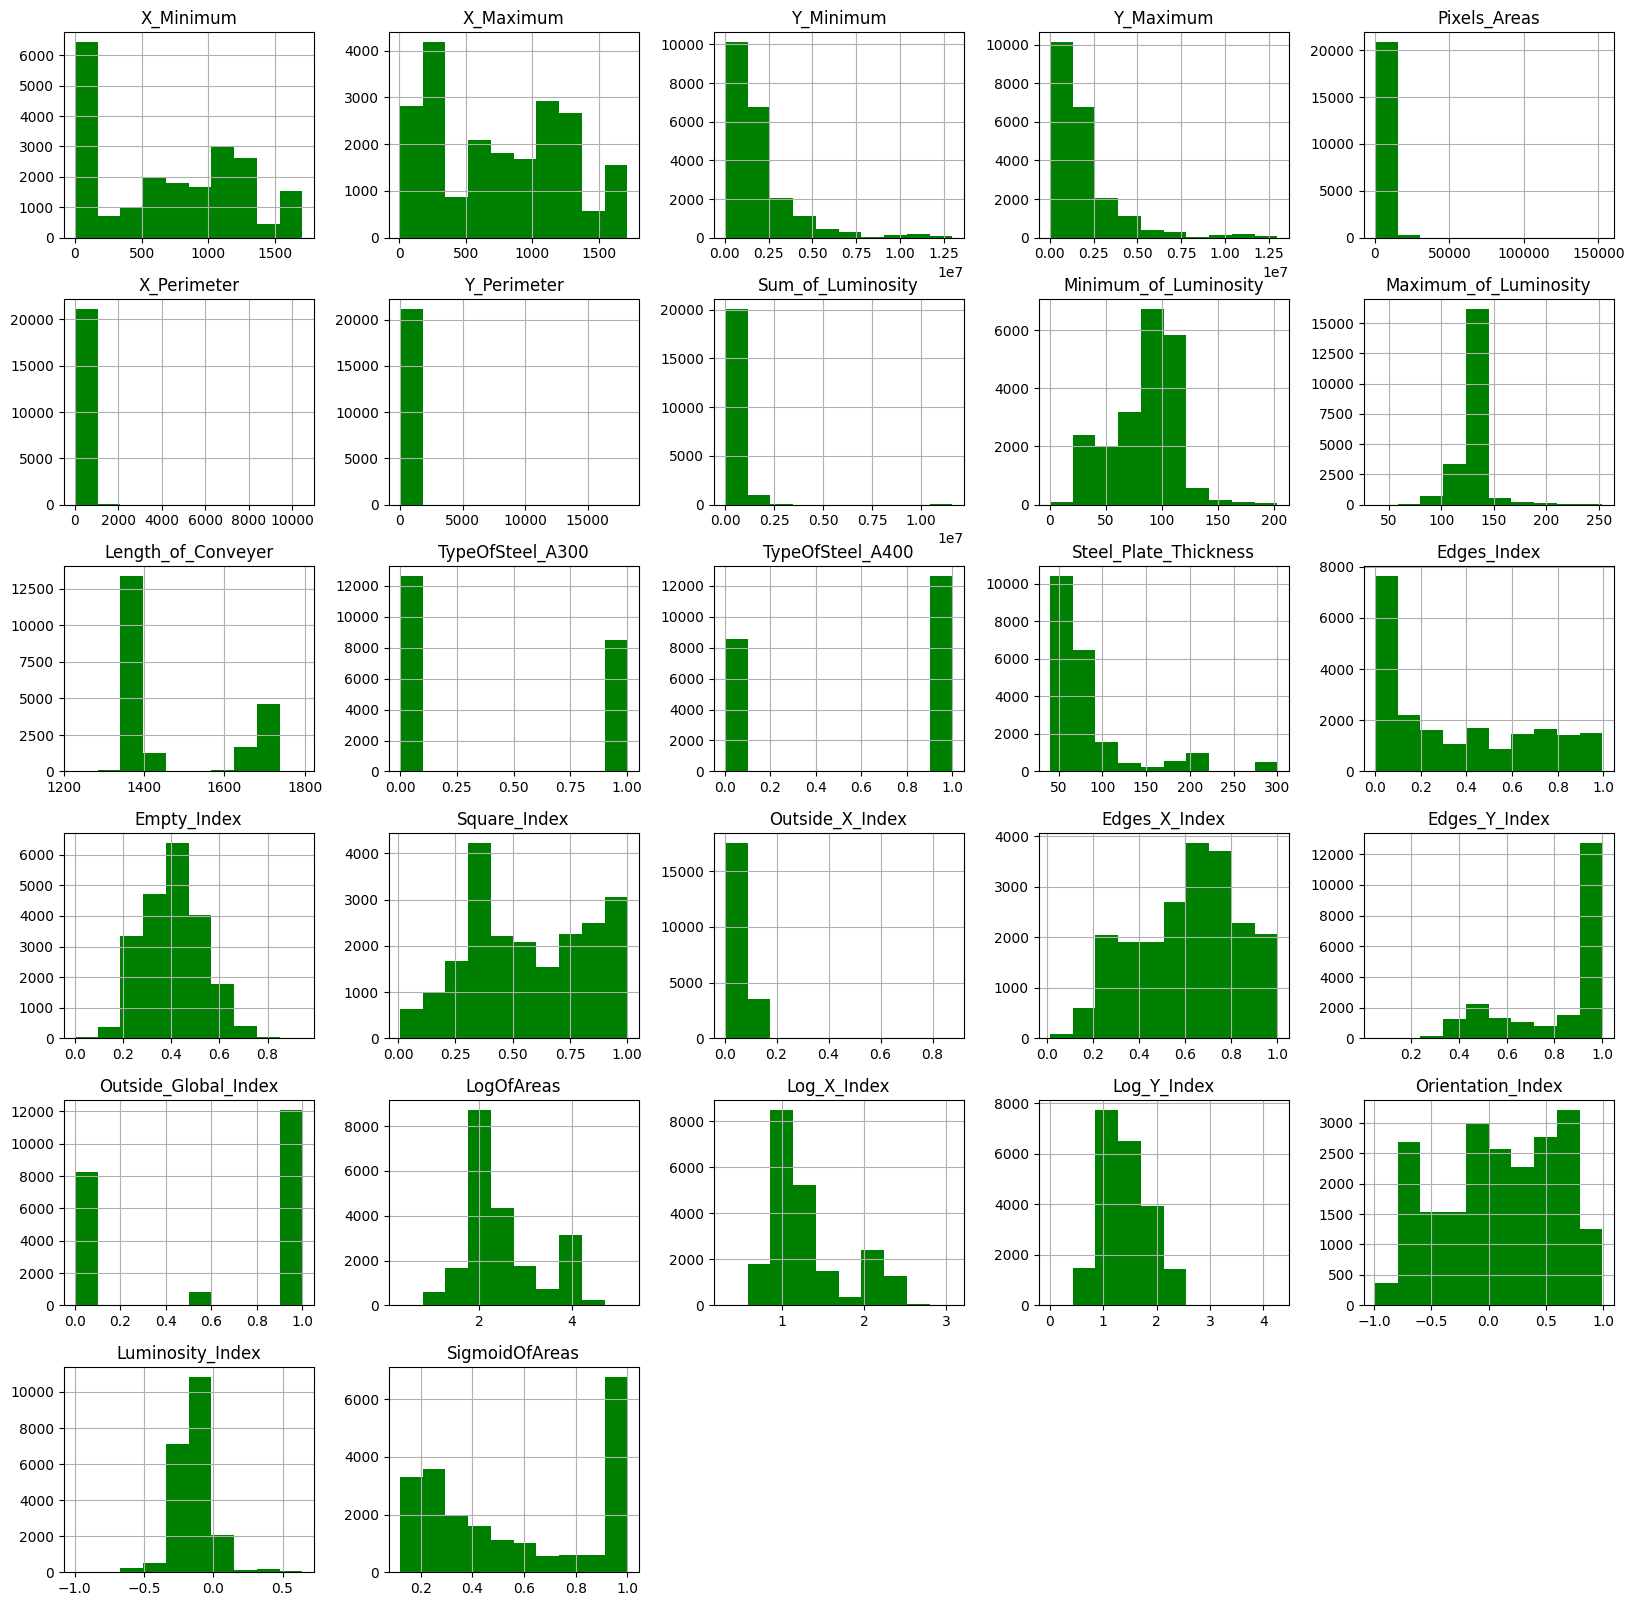

In [ ]:
X_train.hist(figsize=(20,20),color = 'green')
plt.show()

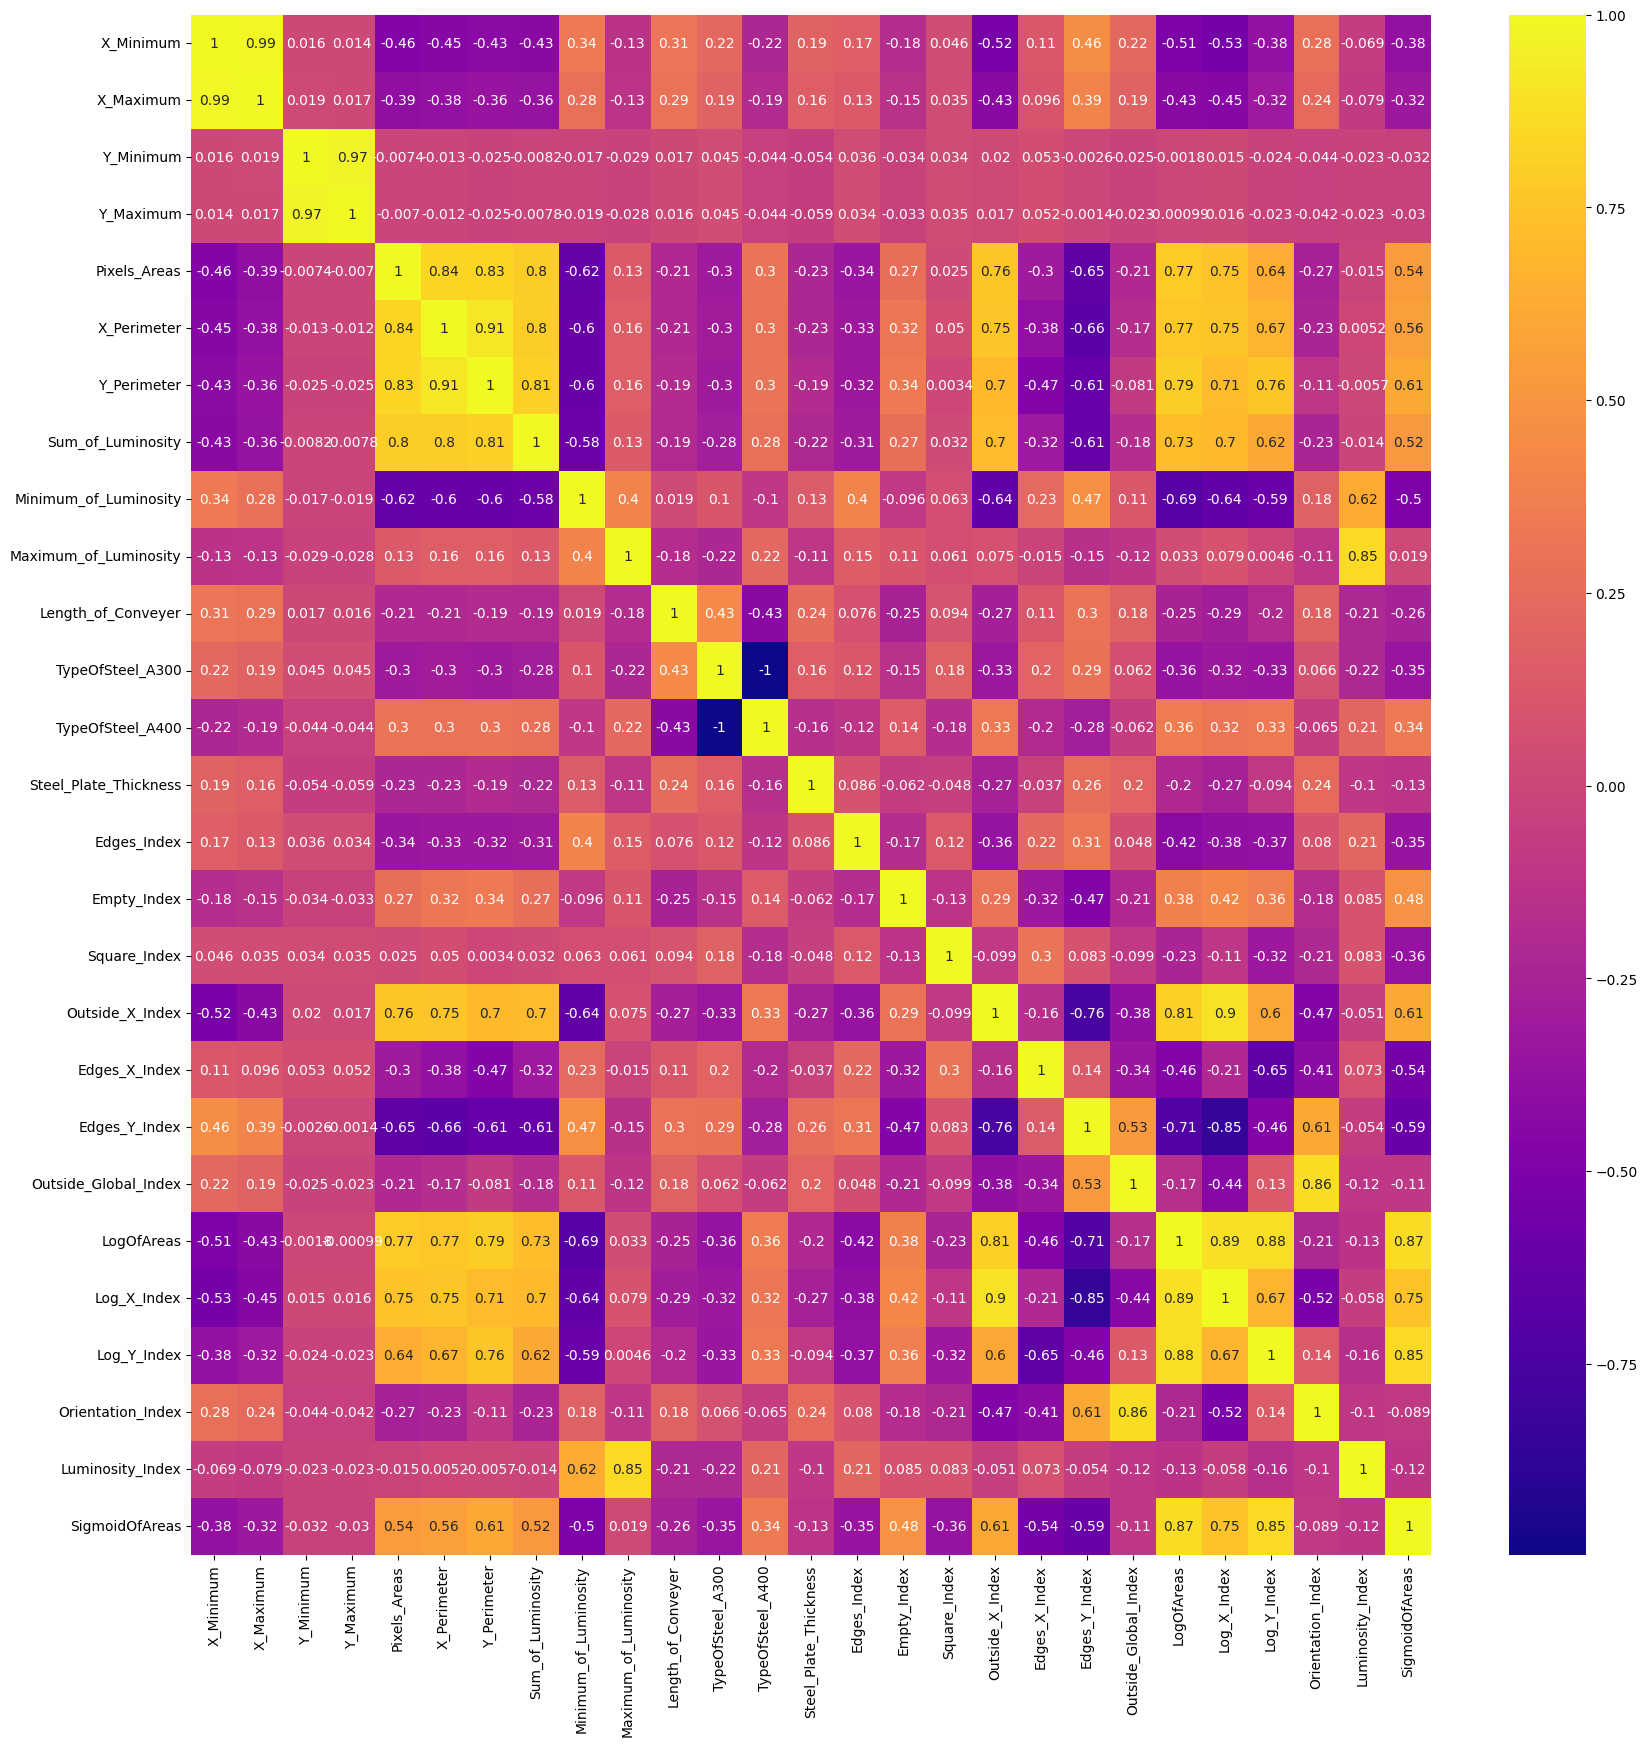

In [ ]:
plt.figure(figsize=(20,20))
corr_matrix = df_train.drop(columns=label_columns).corr()
sns.heatmap(corr_matrix, annot=True,cmap="plasma")
plt.show()

In [ ]:
features=list(X_train)

In [ ]:
print(X_train['TypeOfSteel_A300'].value_counts())
print(X_train['TypeOfSteel_A400'].value_counts())

0    12644
1     8516
Name: TypeOfSteel_A300, dtype: int64
1    12625
0     8535
Name: TypeOfSteel_A400, dtype: int64


In [ ]:
cat_features=['TypeOfSteel_A300','TypeOfSteel_A400']

In [ ]:
for f in cat_features:
    print(X_test[f].value_counts())

0    7622
1    5192
Name: TypeOfSteel_A300, dtype: int64
1    7610
0    5204
Name: TypeOfSteel_A400, dtype: int64


In [ ]:
scale_cols = features.copy()
for f in cat_features:
    scale_cols.remove(f)

In [ ]:
for c in scale_cols:
    min_value = X_train[c].min()
    max_value = X_train[c].max()
    X_train[c] = (X_train[c] - min_value) / (max_value - min_value)
    X_test[c] = (X_test[c] - min_value) / (max_value - min_value)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def adversarial_validation(df_train,df_test):
    X_test  = df_test.select_dtypes(include=['number']).copy()
    X_train = df_train.select_dtypes(include=['number']).copy()

    drop_ = ['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']

    X_train = X_train.drop(drop_, axis=1)
    print(X_train.shape)
    print(X_test.shape)
    X_train["Adv_Val_label"] = 0
    X_test["Adv_Val_label"]  = 1
    all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

    # shuffle
    all_data = all_data.sample(frac=1)
    forest = RandomForestClassifier(random_state=42,max_depth=2,class_weight='balanced')

    X = all_data.drop(['Adv_Val_label'], axis=1).fillna(-1)
    y = all_data['Adv_Val_label']

    clf = RandomForestClassifier(random_state=42).fit(X, y)
    from sklearn.metrics import roc_auc_score
    auc_score = roc_auc_score(y, clf.predict_proba(X)[:,1])
    print(auc_score)


In [ ]:
adversarial_validation(df_train,df_test)

(19219, 27)
(12814, 27)
1.0


In [ ]:
!pip install iterative-stratification

In [ ]:
from xgboost import XGBClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [ ]:
class Model:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.model_dict = dict()
        self.test_predict_list = list()

    def fit(self,params):
        label_columns = ['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']

        train_cols = [col for col in self.train.columns.to_list() if col not in label_columns]
        scores = list()

        for i in range(5):
            mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True)
            oof_valid_preds = np.zeros((self.train[train_cols].shape[0], len(label_columns)))

            for fold, (train_idx, valid_idx) in enumerate(mskf.split(self.train[train_cols], self.train[label_columns])):
                X_train, y_train = self.train[train_cols].iloc[train_idx], self.train[label_columns].iloc[train_idx]
                X_valid, y_valid = self.train[train_cols].iloc[valid_idx], self.train[label_columns].iloc[valid_idx]

                model = XGBClassifier(**params)
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=250,verbose=False)
                valid_preds = model.predict_proba(X_valid)
                oof_valid_preds[valid_idx] = valid_preds
                test_predict = model.predict_proba(self.test[train_cols])
                self.test_predict_list.append(test_predict)
                score = roc_auc_score(y_valid, valid_preds, multi_class="ovr")
                self.model_dict[f'fold_{fold}'] = model
            oof_score = roc_auc_score(self.train[label_columns], oof_valid_preds, multi_class="ovr")
            print(f"The OOF auc score for iteration {i+1} is {oof_score}")
            scores.append(oof_score)
        return scores,self.test_predict_list

In [ ]:
params_1 = {
    "random_state": 18,
    "n_estimators": 1800,
    "learning_rate": 0.006,
    "gamma": 0.44,
    "subsample": 0.7,
    "colsample_bytree": 0.38,
    "max_depth": 5,
    "min_child_weight": 4,
    "reg_lambda": 1.8e-06,
    "reg_alpha": 0.54,
    "booster": "gbtree",
    "verbosity": 0,
    "device_type": "cuda",
    "tree_method": "gpu_hist",
    "grow_policy": "depthwise",
}

params_2 = {
    "n_estimators": 703,
    "learning_rate": 0.023358116742747285,
    "gamma": 0.24997920132991797,
    "subsample": 0.8841265541346639,
    "colsample_bytree": 0.362499715714305,
    "max_depth": 5,
    "min_child_weight": 5,
    "reg_lambda": 2.9660886967874625,
    "reg_alpha": 0.00011509254946941848,
    "booster": "gbtree",
    "verbosity": 0,
    "grow_policy": "depthwise",
    "device_type": "cuda",
    "tree_method": "gpu_hist",
}

params_3 = {
    "verbosity": 0,
    "learning_rate": 0.02767540293640535,
    "n_estimators": 494,
    "reg_alpha": 1.5855453969671037e-06,
    "reg_lambda": 1.4155529076600075,
    "max_depth": 5,
    "colsample_bytree": 0.46589178614541227,
    "subsample": 0.8504122771965839,
    "min_child_weight": 3,
    "device": "cuda",
    "tree_method": "hist",
    "random_state": 18,
}

params_4 = {
    "n_estimators": 1235,
    "learning_rate": 0.008352405007099802,
    "gamma": 0.6499918347241912,
    "subsample": 0.9116532305497375,
    "colsample_bytree": 0.49334879814671045,
    "max_depth": 7,
    "min_child_weight": 1,
    "reg_lambda": 1.7005084366184795,
    "reg_alpha": 0.0059679946773570774,
    "device": "cuda",
    "tree_method": "hist"
}

In [ ]:
X_train_ = pd.concat([X_train, y_train], axis=1,ignore_index=True)
X_train_.columns=features+label_columns

In [ ]:
model = Model(X_train_,X_test)
scores,preds_1 = model.fit(params_1)
print(f'The average roc-auc score is {np.mean(scores)}')
score1=np.mean(scores)

model = Model(X_train_,X_test)
scores,preds_2 = model.fit(params_2)
print(f'The average roc-auc score is {np.mean(scores)}')
score2=np.mean(scores)

model = Model(X_train_,X_test)
scores,preds_3 = model.fit(params_3)
print(f'The average roc-auc score is {np.mean(scores)}')
score3=np.mean(scores)

model = Model(X_train_,X_test)
scores,preds_4 = model.fit(params_4)
print(f'The average roc-auc score is {np.mean(scores)}')
score4=np.mean(scores)

The OOF auc score for iteration 1 is 0.8973233474986125
The OOF auc score for iteration 2 is 0.8968823199891679
The OOF auc score for iteration 3 is 0.8971309032997955
The OOF auc score for iteration 4 is 0.8971039662362393
The OOF auc score for iteration 5 is 0.896754025640516
The average roc-auc score is 0.8970389125328662
The OOF auc score for iteration 1 is 0.8965564192408514
The OOF auc score for iteration 2 is 0.8968156658373813
The OOF auc score for iteration 3 is 0.8970479960537087
The OOF auc score for iteration 4 is 0.8966635534430912
The OOF auc score for iteration 5 is 0.8967999635107101
The average roc-auc score is 0.8967767196171484
The OOF auc score for iteration 1 is 0.8971025192072173
The OOF auc score for iteration 2 is 0.896653754923971
The OOF auc score for iteration 3 is 0.8964226067604237
The OOF auc score for iteration 4 is 0.8970095692281664
The OOF auc score for iteration 5 is 0.8969825456245112
The average roc-auc score is 0.8968341991488579
The OOF auc score 

In [ ]:
predictions_1 = np.mean(preds_1,axis=0)
predictions_2 = np.mean(preds_2,axis=0)
predictions_3 = np.mean(preds_3,axis=0)
predictions_4 = np.mean(preds_4,axis=0)

In [ ]:
predictions = (predictions_1+predictions_2+predictions_3+predictions_4)/4
submit = pd.DataFrame(predictions, columns=['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults'])
submit['id'] = df_test_id
submit.to_csv('submission.csv',index=False)
submit

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,id
0,0.596587,0.001055,0.003240,0.000205,0.016252,0.178168,0.343868,19219
1,0.271180,0.017245,0.005319,0.000309,0.163166,0.155994,0.334917,19220
2,0.001727,0.031403,0.039419,0.000481,0.005295,0.294393,0.510794,19221
3,0.150028,0.001939,0.000598,0.000980,0.008643,0.404220,0.441949,19222
4,0.002445,0.002661,0.000756,0.003510,0.006226,0.623807,0.347952,19223
...,...,...,...,...,...,...,...,...
12809,0.065227,0.075127,0.002177,0.000214,0.017123,0.197064,0.416005,32028
12810,0.157295,0.003481,0.019295,0.006948,0.108194,0.204009,0.395875,32029
12811,0.000654,0.000622,0.927366,0.000253,0.000535,0.000971,0.068672,32030
12812,0.399449,0.010117,0.020435,0.000222,0.060247,0.147211,0.314923,32031
